In [1]:
import os
import re
import upsetplot #the upsetplot implementation in python we are using to make upset plots
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pykrev as pk

import sys
sys.path.append('../mchem_functions/')
import ms_functions_and_defs as msf

In [2]:
general_dir = '../../Data/MS_data' #'../../MS_data
csv_file = 'CSV_files/processed_csv_data_dir/overall_intensity_ordination_table.csv'

samples_to_exclude = ['SRFA','HM-G-Win1']
replicates = 0

In [3]:
# Change directory to the general_dir
try: os.chdir(general_dir)
except FileNotFoundError: pass

In [4]:
ord_table_df = pd.read_csv(csv_file,index_col=['Unnamed: 0'])

ord_table_df = ord_table_df[ord_table_df['replicate_y/n']==replicates].drop(columns=['replicate_y/n'])

In [5]:
sample_names = np.array(ord_table_df.index)
for sample in samples_to_exclude:
    for sample2 in [name for name in sample_names if sample in name]:
        sample_names = sample_names[np.where(sample_names!=sample2)]
ord_table_df = ord_table_df.loc[sample_names]

ord_table_df = ord_table_df.fillna(0)
ord_table_df[ord_table_df>0] = 1
# ord_table_df

In [6]:
groups = ['HM-Aut','HM-Win1','HM-Win2',
          'AM-Aut','AM-Win1','AM-Win2']

seas_site_groups = {}
molec_classes = []
for g in groups:
    seas_site_groups[g] = ord_table_df.loc[sample_names[np.where([g.split('-')[0] in x and g.split('-')[1] in x for x in sample_names])]]

    seas_site_groups[g] = np.array(seas_site_groups[g].columns[np.any(seas_site_groups[g],axis=0)])
# seas_site_groups

In [7]:
sample_dict = {}

for sample in sample_names:
    sample_dict[sample] = np.array(ord_table_df.loc[sample].index[ord_table_df.loc[sample].values != 0])

In [8]:
sample_upset = upsetplot.from_contents(seas_site_groups)

In [9]:
formula_to_analyse = sample_upset['id'] #a set of all the formula across all the samples
msTuple = pk.msTuple(formula_to_analyse, [], []) #transform the formula_to_analyse into an msTuple, we can ignore the intensity and mass values
counts = pk.element_counts(msTuple) #calculate the element counts for all the formula
o_number = [c['O'] for c in counts] #calculate the oxygen number for all the formula
dbe = pk.double_bond_equivalent(msTuple) #calculate the double bond equivalence for all the formula

In [10]:
molec_class_dict = [msf.molecclass(pd.DataFrame(msf.MolecFormulaDict(x),index=[x])) for x in msTuple.formula.values]
compoundClass = [[key for key in x if len(x[key])>0][0] for x in molec_class_dict]
# compoundClass = pk.compound_class(msTuple, method= 'ELEM')[0]

In [19]:
data_add = pd.DataFrame({'dbe':dbe, 'compound class': compoundClass, 'Compound':formula_to_analyse, 'o number':o_number})
#index the dataframe by the molecular formula
data_add = data_add.set_index('Compound')
#reperform the intersection analysis including the additional data 
re_upset = upsetplot.from_contents(seas_site_groups,data=data_add)
#perform upset analysis on the resulting series
upset = upsetplot.UpSet(re_upset, show_counts=True, show_percentages = True, sort_categories_by = None,  intersection_plot_elements = 0, orientation='horizontal', element_size = 80)
# make the count bars correspond to elemental class
upset.add_stacked_bars(by="compound class", elements = 8, title = "Count", colors = [value for key, value in sorted(msf.vk_region_colours.items())])

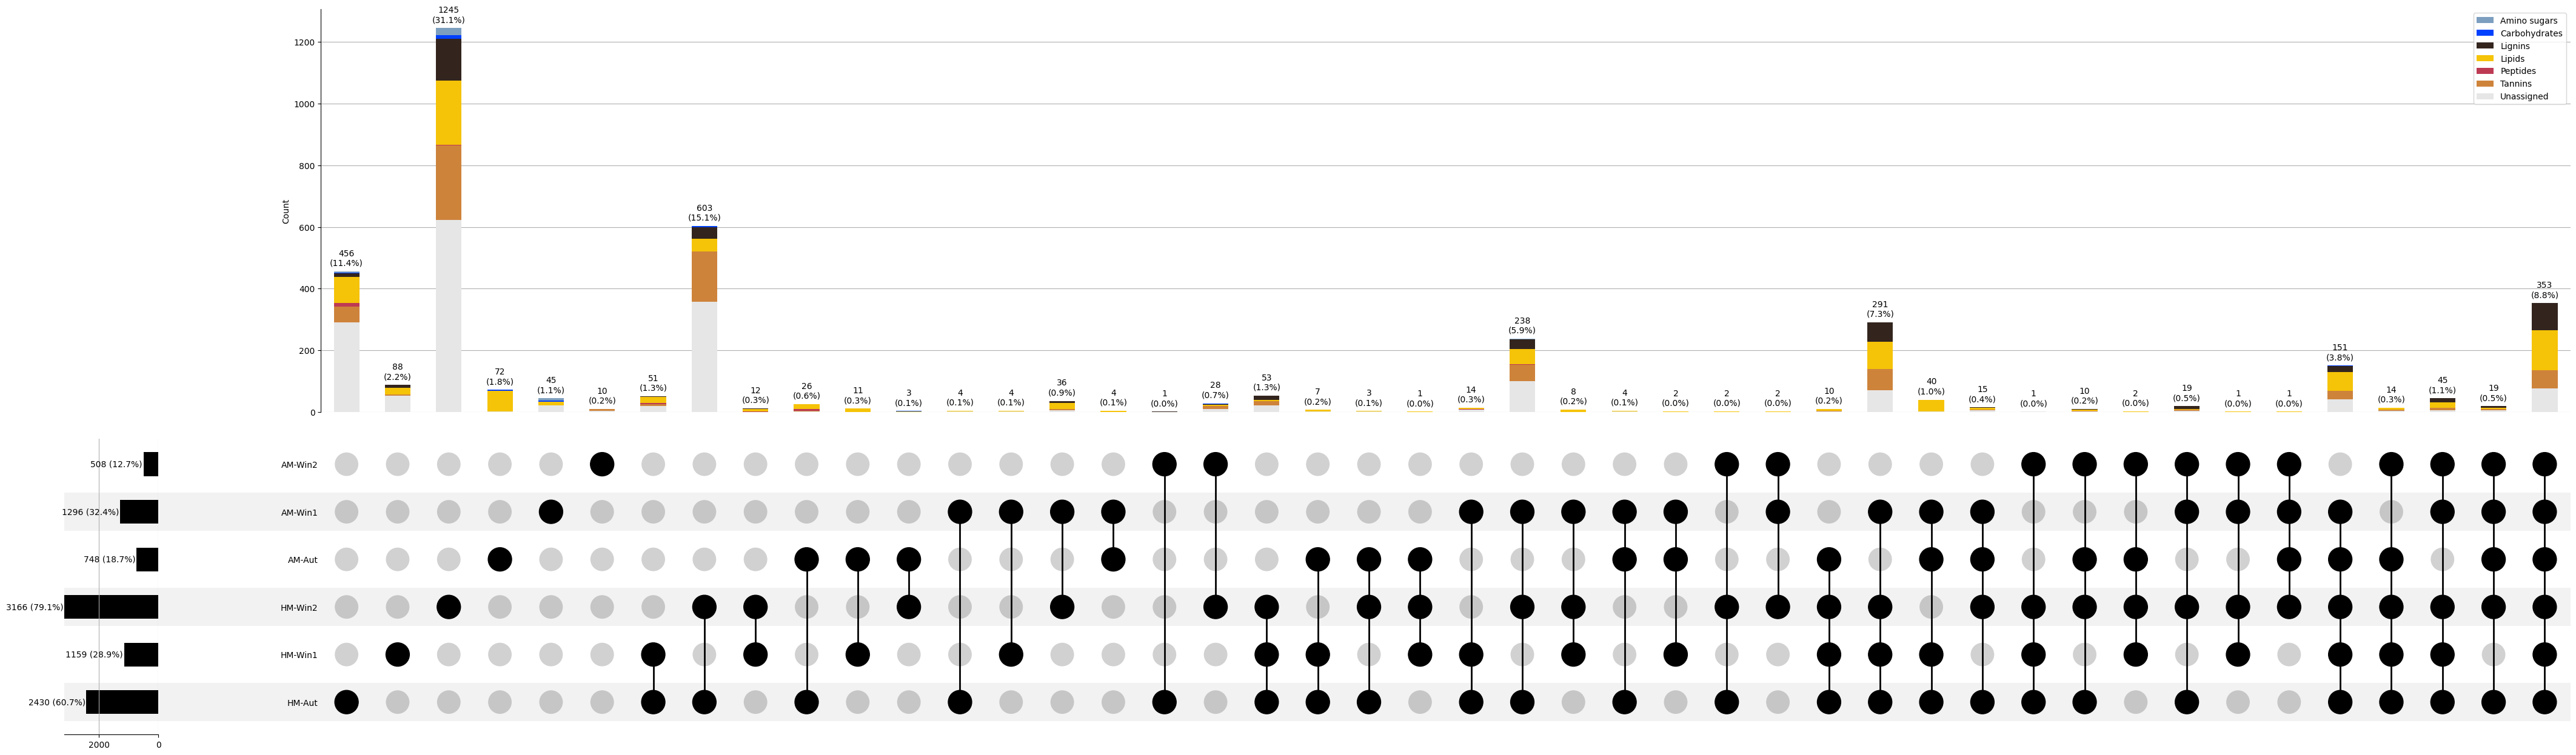

In [24]:
#finally make the plot and save the returned handles 
fig_upset = plt.figure()
upset_returns = upset.plot(fig=fig_upset)
fig_upset.savefig('plots/upset_plot.svg', dpi=600, facecolor = '#fffa', bbox_inches='tight')